<a href="https://colab.research.google.com/github/hungryjins/Machine_learning/blob/main/crime_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# https://opendata.vancouver.ca/pages/home/
#https://www.kaggle.com/datasets/wosaku/crime-in-vancouver?resource=download

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [1]:
! pip install keras-hypetune # keras grid search
! pip install fitter # GEV distribution generation

In [2]:
import os
import random
import warnings
import numpy as np
from scipy import stats
from fitter import Fitter
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from kerashypetune import KerasGridSearch

Download csv file from my github readme.md file and set file path in your local drive.

In [3]:
## Read data

filepath = '/content/gdrive/MyDrive/machine learning/crime.csv'
df = pd.read_csv(filepath)
df['Date'] = pd.to_datetime(df[['YEAR','MONTH','DAY']])

df = pd.DataFrame({'n_crimes':df.Date.value_counts().sort_index()})
df['month'] = df.index.month
df['wday'] = df.index.dayofweek
df['day'] = df.index.day

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5308 entries, 2003-01-01 to 2017-07-13
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   n_crimes  5308 non-null   int64
 1   month     5308 non-null   int32
 2   wday      5308 non-null   int32
 3   day       5308 non-null   int32
dtypes: int32(3), int64(1)
memory usage: 145.1 KB


In [4]:
print(df.head())

            n_crimes  month  wday  day
Date                                  
2003-01-01       191      1     2    1
2003-01-02       148      1     3    2
2003-01-03       160      1     4    3
2003-01-04       146      1     5    4
2003-01-05       120      1     6    5


In [5]:
print(df.tail())

            n_crimes  month  wday  day
Date                                  
2017-07-09       119      7     6    9
2017-07-10       100      7     0   10
2017-07-11       104      7     1   11
2017-07-12        96      7     2   12
2017-07-13        51      7     3   13


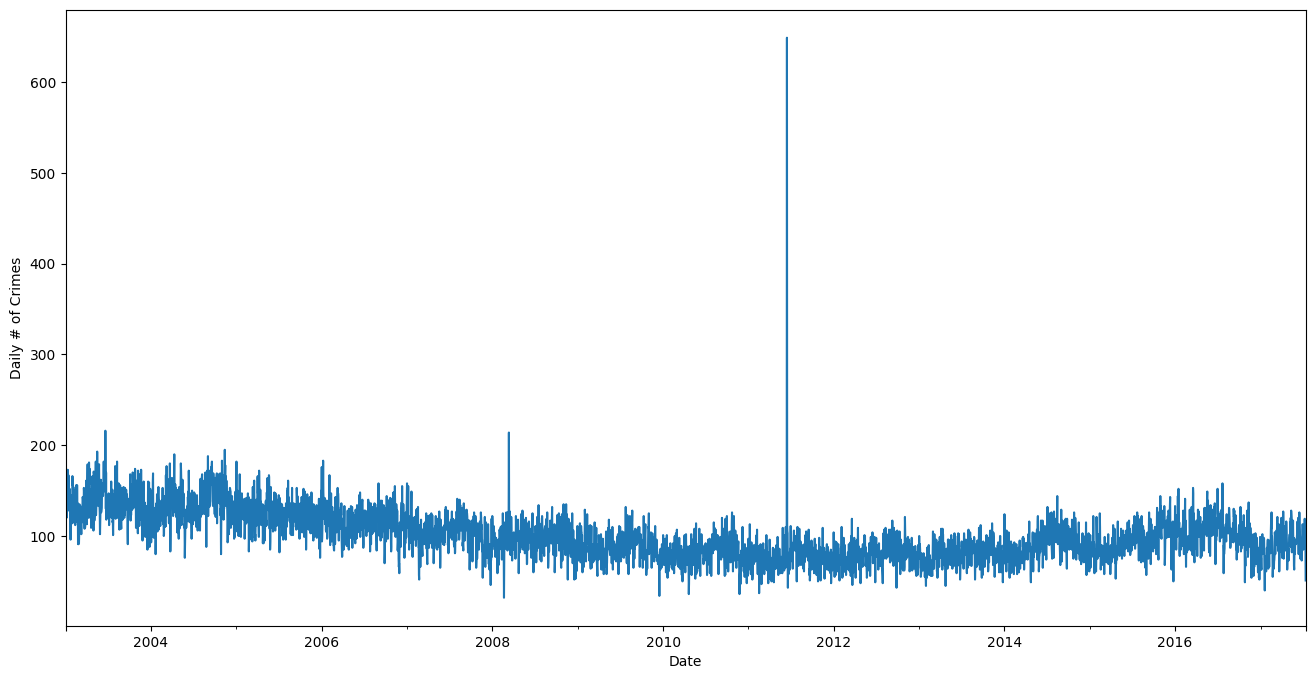

In [6]:
## Plot aggregated daily crimes

df.n_crimes.plot(figsize=(16,8))
plt.ylabel('Daily # of Crimes')
plt.show()

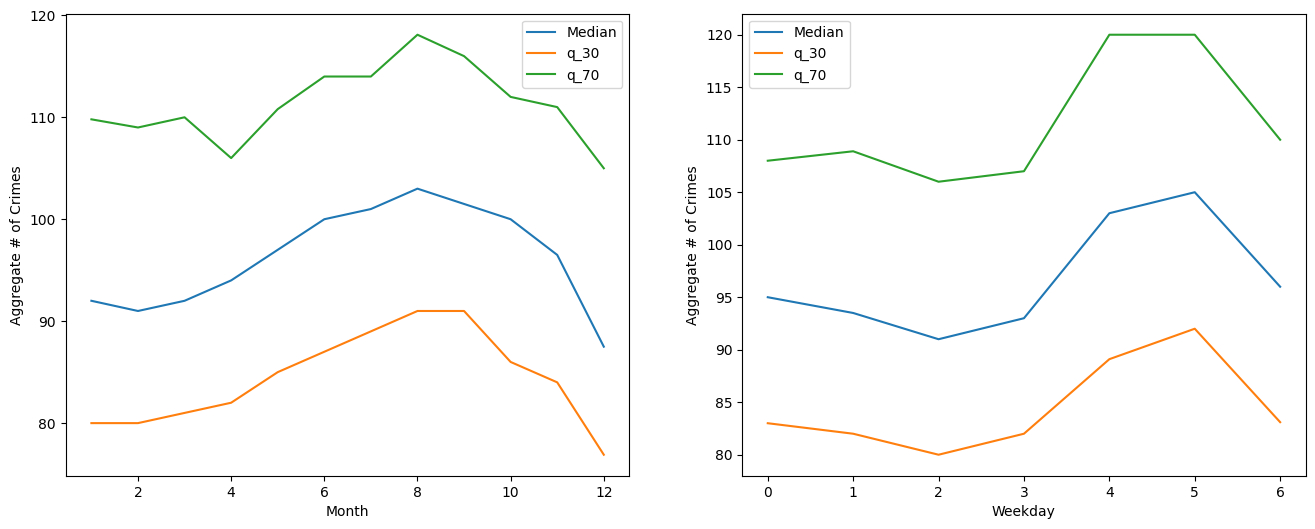

In [7]:
## Plot seasonality

plt.figure(figsize=(16,6))

plt.subplot(121)
df.n_crimes.groupby(df.index.month).median().rename('Median').plot(ax=plt.gca(), legend=True)
df.n_crimes.groupby(df.index.month).apply(np.quantile, 0.3).rename('q_30').plot(legend=True)
df.n_crimes.groupby(df.index.month).apply(np.quantile, 0.7).rename('q_70').plot(legend=True)
plt.ylabel('Aggregate # of Crimes'); plt.xlabel('Month')

plt.subplot(122)
df.n_crimes.groupby(df.index.weekday).median().rename('Median').plot(ax=plt.gca(), legend=True)
df.n_crimes.groupby(df.index.weekday).apply(np.quantile, 0.3).rename('q_30').plot(legend=True)
df.n_crimes.groupby(df.index.weekday).apply(np.quantile, 0.7).rename('q_70').plot(legend=True)
plt.ylabel('Aggregate # of Crimes'); plt.xlabel('Weekday')

plt.show()

In [8]:
## Define utility functions

def create_windows(data, window_shape, step = 1, start_id = None, end_id = None):

    data = np.asarray(data)
    data = data.reshape(-1,1) if np.prod(data.shape) == max(data.shape) else data

    start_id = 0 if start_id is None else start_id
    end_id = data.shape[0] if end_id is None else end_id

    data = data[int(start_id):int(end_id),:]
    window_shape = (int(window_shape), data.shape[-1])
    step = (int(step),) * data.ndim
    slices = tuple(slice(None, None, st) for st in step)
    indexing_strides = data[slices].strides
    win_indices_shape = ((np.array(data.shape) - window_shape) // step) + 1

    new_shape = tuple(list(win_indices_shape) + list(window_shape))
    strides = tuple(list(indexing_strides) + list(data.strides))

    window_data = np.lib.stride_tricks.as_strided(data, shape=new_shape, strides=strides)

    return np.squeeze(window_data, 1)


class Scaler3D:

    def fit(self, X):
        self.mean = X.reshape(-1,X.shape[-1]).mean(0).reshape(1,1,-1)
        self.std = X.reshape(-1,X.shape[-1]).std(0).reshape(1,1,-1)
        return self

    def transform(self, X):
        return (X - self.mean) / self.std

    def inverse_transform(self, X):
        return (X * self.std) + self.mean


def prepare_seq(num_X, cat1_X, cat2_X, scaler=None):

    if scaler is not None:
        num_X = scaler.transform(num_X)

    inp_dict = {}
    inp_dict['inp_num'] = num_X
    for i,c in enumerate(cat_var):
        inp_dict[f"inp_{c}_cat1"] = cat1_X[:,:,i]
        inp_dict[f"inp_{c}_cat2"] = cat2_X[:,:,i]

    return inp_dict

In [9]:
### Split train & test, apply scaler

time_h = 7
window_shape = 21

target = ['n_crimes']
cat_var = ['month','wday','day']

_id_train, _id_valid = train_test_split(np.arange((len(df) - window_shape - time_h + 1)), test_size=0.3, shuffle=False)

_num_X = create_windows(df[target], window_shape=window_shape, end_id=-time_h)
_cat1_X = create_windows(df[cat_var], window_shape=window_shape, end_id=-time_h)
_cat2_X = create_windows(df[cat_var], window_shape=time_h, start_id=window_shape)
_target = create_windows(df[target], window_shape=time_h, start_id=window_shape)

_num_X_train = _num_X[_id_train]; _num_X_valid = _num_X[_id_valid]
_cat1_X_train = _cat1_X[_id_train]; _cat1_X_valid = _cat1_X[_id_valid]
_cat2_X_train = _cat2_X[_id_train]; _cat2_X_valid = _cat2_X[_id_valid]
_target_train = _target[_id_train]; _target_valid = _target[_id_valid]

X_scaler = Scaler3D().fit(_num_X_train)
y_scaler = Scaler3D().fit(_target_train)

X_train = prepare_seq(_num_X_train, _cat1_X_train, _cat2_X_train, scaler=X_scaler)
y_train = y_scaler.transform(_target_train)
X_valid = prepare_seq(_num_X_valid, _cat1_X_valid, _cat2_X_valid, scaler=X_scaler)
y_valid = y_scaler.transform(_target_valid)

In [12]:
### Define Model

def set_seed(seed):

    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)


def get_model(param):

    set_seed(33)

    inp_num = Input((window_shape,1), name='inp_num')

    embeddings = {
        'month': Embedding(12+1, param['emb_dim']),
        'wday': Embedding(6+1, param['emb_dim']),
        'day': Embedding(31+1, param['emb_dim'])
    }

    inp_cat1, emb_cat = [], []
    for c in cat_var:
        _inp_c1 = Input((window_shape,), name=f"inp_{c}_cat1")
        emb = embeddings[c](_inp_c1)
        inp_cat1.append(_inp_c1)
        emb_cat.append(emb)

    enc = Concatenate()([inp_num] + emb_cat)
    enc = LSTM(param['lstm_unit'], return_sequences=False)(enc)

    inp_cat2, emb_future = [], []
    for c in cat_var:
        _inp_c2 = Input((time_h,), name=f"inp_{c}_cat2")
        emb = embeddings[c](_inp_c2)
        inp_cat2.append(_inp_c2)
        emb_future.append(emb)

    x = RepeatVector(time_h)(enc)
    dec = Concatenate()([x] + emb_future)
    dec = LSTM(param['lstm_unit'], return_sequences=True)(dec)

    output = TimeDistributed(Dense(1))(dec)

    model = Model([inp_num] + inp_cat1 + inp_cat2, output)
    model.compile(Adam(learning_rate=param['lr']), 'mse')

    return model

In [13]:
## Modeling Fitting

param_grid = {
    'lstm_unit': [128,64,32],
    'emb_dim': [8,16,32],
    'lr': [1e-4,1e-3], ## learning rate
    'epochs': 100,
    'batch_size': 64
}

es = EarlyStopping(patience=7, verbose=0, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)
hypermodel = get_model
kgs = KerasGridSearch(hypermodel, param_grid, monitor='val_loss', greater_is_better=False, tuner_verbose=1)
kgs.search(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[es])


18 trials detected for ('lstm_unit', 'emb_dim', 'lr', 'epochs', 'batch_size')

***** (1/18) *****
Search({'lstm_unit': 128, 'emb_dim': 8, 'lr': 0.0001, 'epochs': 100, 'batch_size': 64})
SCORE: 0.22019 at epoch 18

***** (2/18) *****
Search({'lstm_unit': 128, 'emb_dim': 8, 'lr': 0.001, 'epochs': 100, 'batch_size': 64})
SCORE: 0.22112 at epoch 8

***** (3/18) *****
Search({'lstm_unit': 128, 'emb_dim': 16, 'lr': 0.0001, 'epochs': 100, 'batch_size': 64})
SCORE: 0.2208 at epoch 15

***** (4/18) *****
Search({'lstm_unit': 128, 'emb_dim': 16, 'lr': 0.001, 'epochs': 100, 'batch_size': 64})
SCORE: 0.2219 at epoch 4

***** (5/18) *****
Search({'lstm_unit': 128, 'emb_dim': 32, 'lr': 0.0001, 'epochs': 100, 'batch_size': 64})
SCORE: 0.22102 at epoch 13

***** (6/18) *****
Search({'lstm_unit': 128, 'emb_dim': 32, 'lr': 0.001, 'epochs': 100, 'batch_size': 64})
SCORE: 0.2219 at epoch 4

***** (7/18) *****
Search({'lstm_unit': 32, 'emb_dim': 8, 'lr': 0.0001, 'epochs': 100, 'batch_size': 64})
SCORE: 0.

In [14]:
print('BEST PARAM:', kgs.best_params)

BEST PARAM: {'lstm_unit': 64, 'emb_dim': 8, 'lr': 0.001, 'epochs': 9, 'batch_size': 64, 'steps_per_epoch': 58}


In [15]:
## Get predicted values

pred = np.squeeze(
    y_scaler.inverse_transform(
        kgs.best_model.predict(X_valid)
    ), -1)

y_valid = np.squeeze(y_scaler.inverse_transform(y_valid), -1)

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


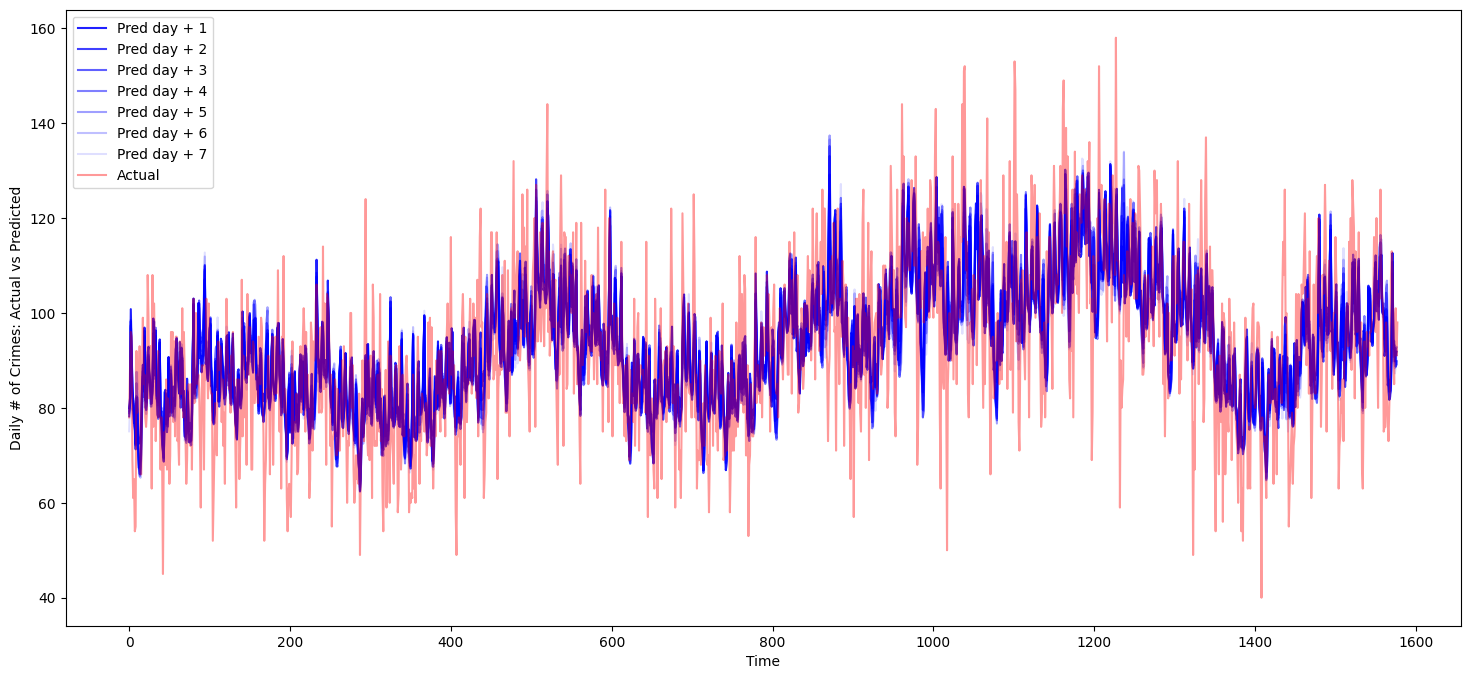

In [16]:
## Visualize Test vs Predicted
## Test vs prediction values are on different time horizons

plt.figure(figsize=(18,8))

for t_h in range(time_h):
    plt.plot(pred[(time_h-t_h):-(t_h+1),t_h],
             c='blue', alpha=1-1/(time_h+1)*(t_h+1),
             label=f"Pred day + {t_h+1}")

plt.plot(y_valid[time_h:,0], c='red', alpha=0.4, label='Actual')

plt.ylabel('Daily # of Crimes: Actual vs Predicted')
plt.xlabel('Time')
plt.legend()
plt.show()

In [17]:
## Get model and baseline mse

mse_model = {}
mse_baseline = {}

for t_h in range(time_h):

    _mse = mse(y_valid[1:,t_h], y_valid[:-1,0])
    mse_baseline[f"day + {t_h+1}"] = _mse

    _mse = mse(y_valid[:,t_h], pred[:,t_h])
    mse_model[f"day + {t_h+1}"] = _mse

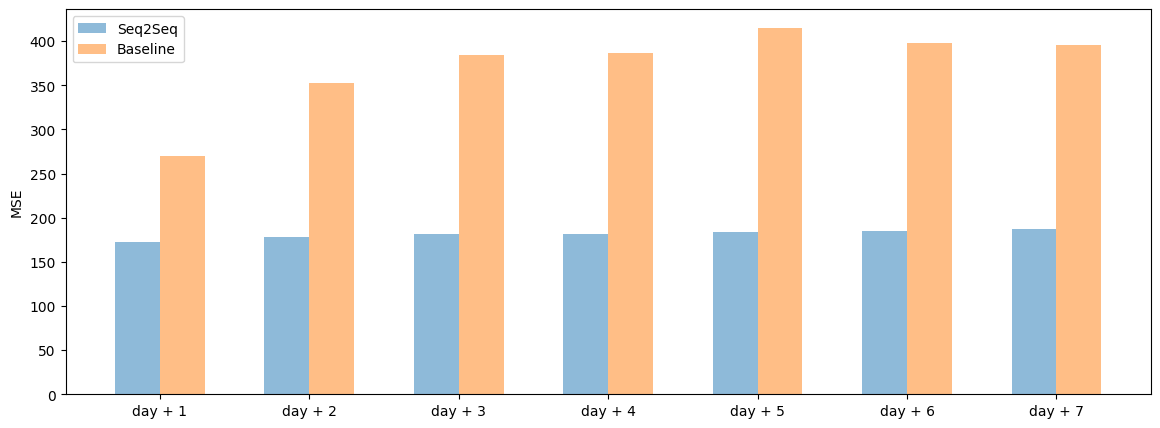

In [18]:
## Plot MSEs
## MSEs are computed on different time horizons

plt.figure(figsize=(14,5))

plt.bar(np.arange(len(mse_model))-0.15, mse_model.values(), alpha=0.5, width=0.3, label='Seq2Seq')
plt.bar(np.arange(len(mse_baseline))+0.15, mse_baseline.values(), alpha=0.5, width=0.3, label='Baseline')
plt.xticks(range(len(mse_baseline)), mse_baseline.keys())
plt.ylabel('MSE')
plt.legend()
plt.show()

# Advanced Point: Improving Time Series Predictions with High Outliers using Generalized Extreme Value (GEV) Distribution

In [19]:
# Extreme Value

In [20]:
## Get residuals

t_h = 1 # desired time forecasting horizon to compute the EVA

resid = np.abs(y_valid[:,t_h] - pred[:,t_h])
data = pd.Series(resid, index=(df.iloc[_id_valid[0]:_id_valid[-1]+1]).index, name='resid')

/tmp/ipython-input-2145345664.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.scatter(data[data.resample('1M').apply(lambda x: x.idxmax()).values].index,
/tmp/ipython-input-2145345664.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data[data.resample('1M').apply(lambda x: x.idxmax()).values].values, c='red')
/tmp/ipython-input-2145345664.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data = data.resample('1M').max()


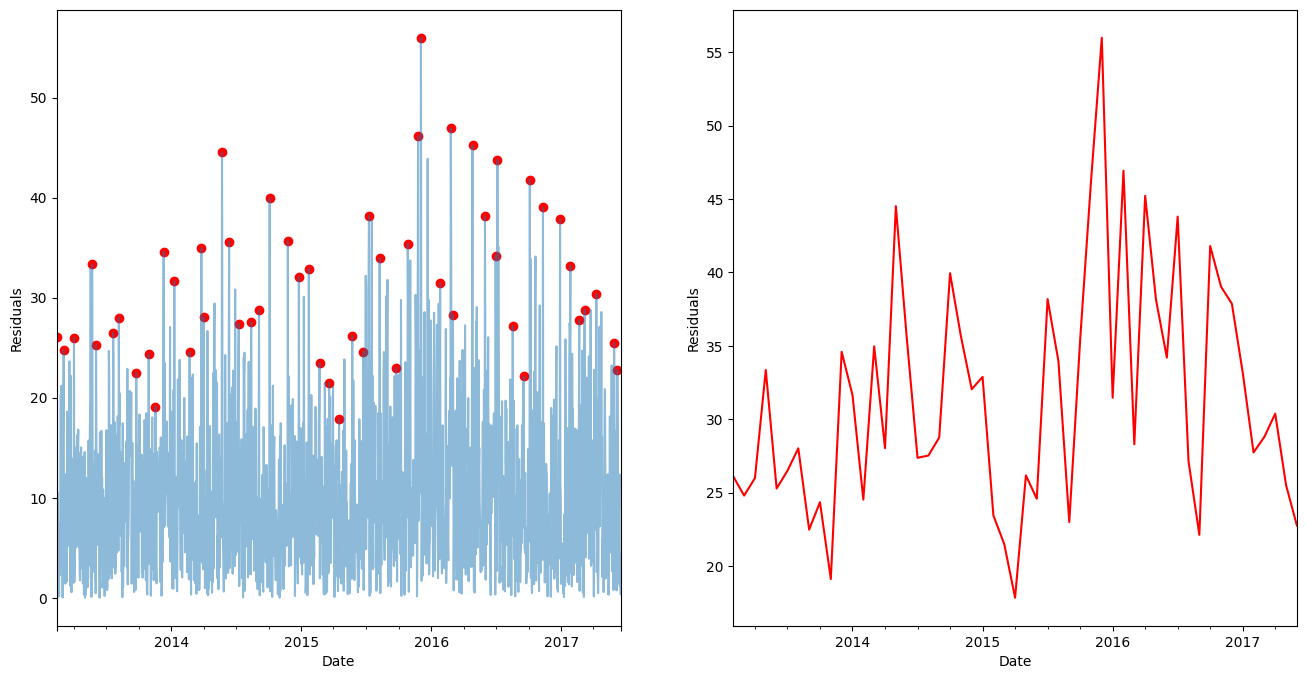

In [21]:
## Plot block maxima

plt.figure(figsize=(16,8))

plt.subplot(121)
data.plot(ax=plt.gca(), alpha=0.5)
plt.scatter(data[data.resample('1M').apply(lambda x: x.idxmax()).values].index,
            data[data.resample('1M').apply(lambda x: x.idxmax()).values].values, c='red')
plt.ylabel('Residuals')

plt.subplot(122)
data = data.resample('1M').max()
data.plot(ax=plt.gca(), c='red')
plt.ylabel('Residuals')
plt.show()

In [22]:
## Utiliy functions to create bootstrap

def bootstrap_ci(
    data,
    statfunction=np.average,
    alpha = 0.05,
    n_samples = 100):

    def bootstrap_ids(data, n_samples=100):
        for _ in range(n_samples):
            yield np.random.randint(data.shape[0], size=(data.shape[0],))

    alphas = np.array([alpha/2, 1 - alpha/2])
    nvals = np.round((n_samples - 1) * alphas).astype(int)
    # if np.any(nvals < 10) or np.any(nvals >= n_samples-10):
    #     warnings.warn("Some values used extremal samples; results are probably unstable. "
    #                   "Try to increase n_samples")

    data = np.array(data)
    # if np.prod(data.shape) != max(data.shape):
    #     raise ValueError("Data must be 1D")
    data = data.ravel()

    boot_indexes = bootstrap_ids(data, n_samples)
    stat = np.asarray([statfunction(data[_ids]) for _ids in boot_indexes])
    stat.sort(axis=0)

    return stat[nvals]

In [23]:
## Get distribution for exreme residuals

f = Fitter(data, distributions=['genextreme','gumbel_r'], bins=20) # GEV, Gumbel distribution
f.fit()

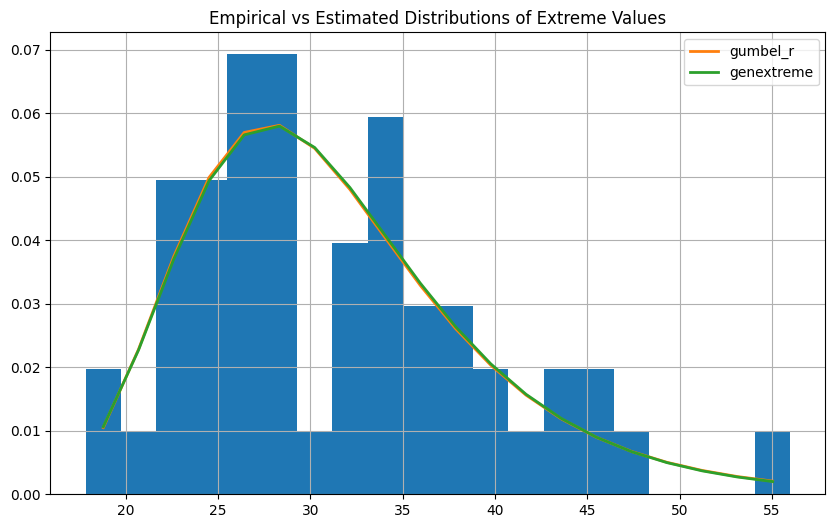

In [24]:
## Plot distribution for extreme residuals
plt.figure(figsize=(10,6))
f.summary()
plt.title('Empirical vs Estimated Distributions of Extreme Values')
plt.show()

In [25]:
best_dist = eval(f"stats.{list(f.get_best().keys())[0]}")
f.get_best() # c is close to 0

{'gumbel_r': {'loc': 27.74582647425078, 'scale': 6.30865917339098}}

In [26]:
## Get estimated params from the best distribution

best_params = best_dist.fit(data)
best_params

(27.74582647425078, 6.30865917339098)

In [27]:
## Calculate bootstrap intervals for the estimted best params

np.random.seed(111)
ci_params = bootstrap_ci(data, best_dist.fit, n_samples=500)
ci_params

array([[26.09334049,  5.07544072],
       [29.65134519,  7.57250717]])

In [28]:
## Define return periods & estimted return values

eps = 1e-1
T = np.arange(1, 1000, eps) + eps # return periods
q = 1-1/T
ppf = best_dist.ppf(q, *best_params) # return values

In [29]:
## Calculate bootstrap intervals for the estimted return values

def gen_ppf(data, q):

    new_param = best_dist.fit(data)
    ppf = best_dist.ppf(q, *new_param)

    return ppf

np.random.seed(111)
ci_ppf = bootstrap_ci(data, lambda x: gen_ppf(x, q), n_samples=500, alpha=0.05)
ci_ppf

array([[20.71056308, 22.53776272, 23.77761888, ..., 62.04110414,
        62.04161201, 62.04211984],
       [24.23003133, 25.90941764, 27.13393283, ..., 80.96645417,
        80.96721192, 80.96796959]])

Test Result&Analysis

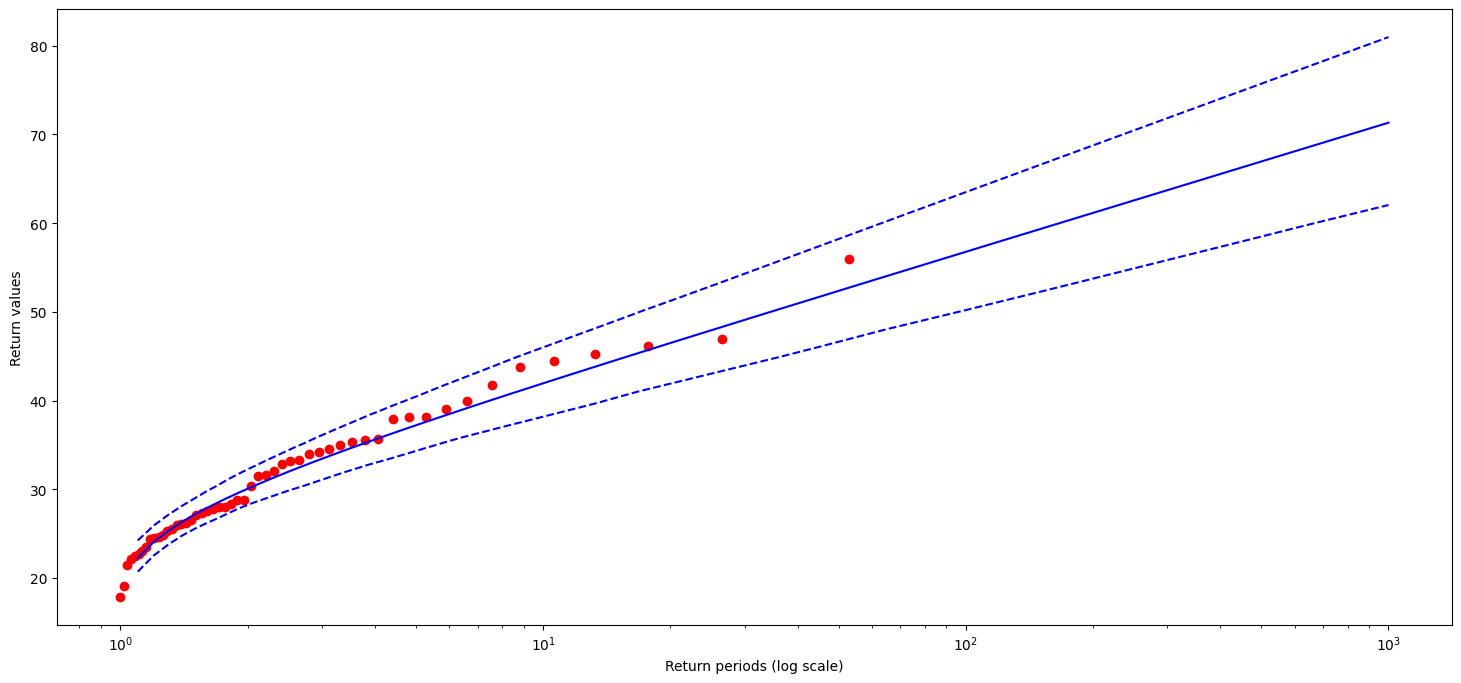

In [30]:
## Plot return values

plt.figure(figsize=(18,8))

plt.semilogx(T, ppf, c='b')
plt.semilogx(T, ci_ppf[0], c='b', linestyle='--')
plt.semilogx(T, ci_ppf[1], c='b', linestyle='--')

N = np.arange(1, len(data)+1)
plt.scatter(N[-1]/N, sorted(data)[::-1], color = 'red')
plt.ylabel('Return values')
plt.xlabel('Return periods (log scale)')
plt.show()

In [31]:
## Create a summary

eps = 1e-1
T = np.asarray([1, 2, 5, 10, 25, 50, 100]) + eps
q = 1-1/T
ppf = best_dist.ppf(q, *best_params)

np.random.seed(111)
ci_ppf = bootstrap_ci(data, lambda x: gen_ppf(x, q), n_samples=500, alpha=0.05)

summary = pd.DataFrame({
    'return_period':(T-eps).astype(int),
    'lower_ci':ci_ppf[0],
    'return_value':ppf,
    'upper_ci':ci_ppf[-1]
}).set_index('return_period')

summary

,lower_ci,return_value,upper_ci
return_period,,,
1,20.710563,22.228328,24.230031
2,28.605092,30.496310,32.714141
5,34.439981,37.348222,40.599291
10,38.232599,42.008808,46.068617
25,43.050930,47.949993,52.944250
50,46.637910,52.374560,58.225275
100,50.200212,56.772937,63.504849
